## Graph Attention basics.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

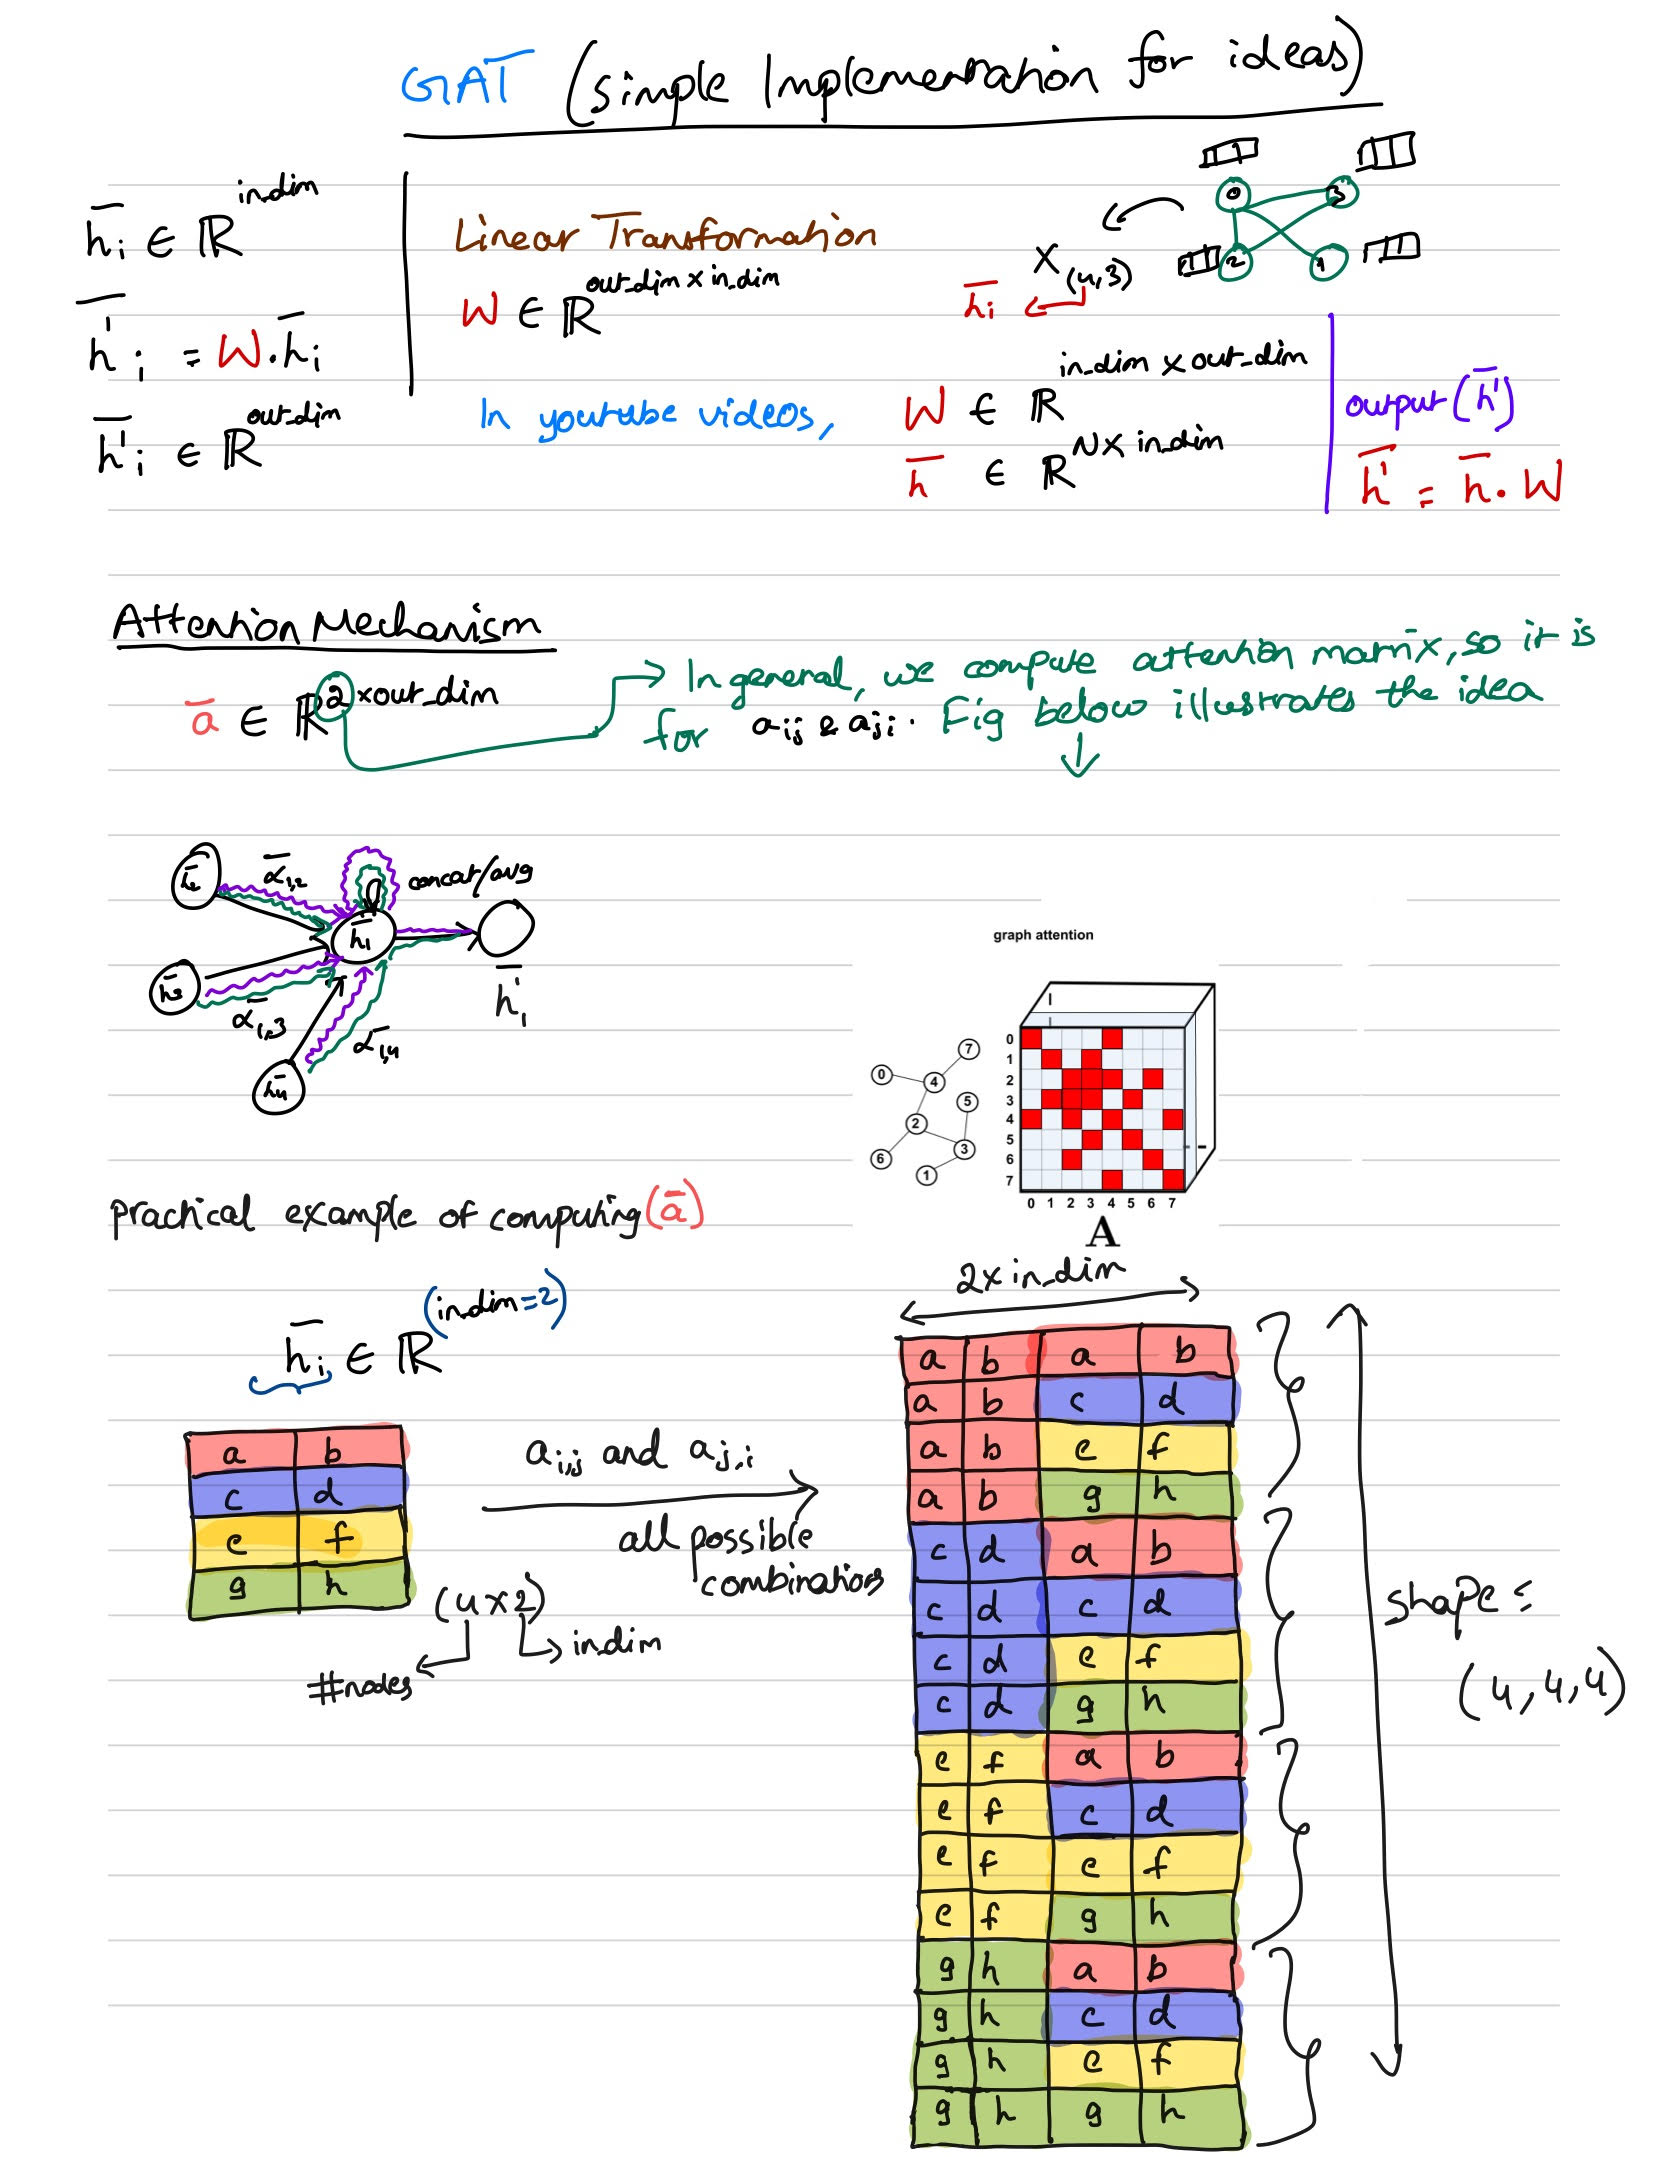

In [2]:
in_dim = 5
out_dim = 2
num_nodes = 3

#Xavier initialization of W
W = nn.Parameter(torch.zeros(size = (in_dim, out_dim)), requires_grad = True)
nn.init.xavier_uniform_(W.data, gain = 1.414)

print("The shape of W is {}".format(W.shape))
h = torch.rand(size = (num_nodes, in_dim))
print("The shape of h is {}".format(h.shape))
h_dash = torch.matmul(h, W)

print("The shape of h_dash is {}".format(h_dash.shape))

The shape of W is torch.Size([5, 2])
The shape of h is torch.Size([3, 5])
The shape of h_dash is torch.Size([3, 2])


## Attention Mechanism


In [3]:
#Xavier initialization of a
a = nn.Parameter(torch.zeros(size = (2*out_dim, 1)), requires_grad = True)
nn.init.xavier_uniform_(a.data, gain = 1.414)

print("The shape of a is {}".format(a.shape))

leaky_relu = nn.LeakyReLU(0.2)

The shape of a is torch.Size([4, 1])


In [4]:
a_input = torch.cat([h_dash.repeat(1, h_dash.shape[0]).view(h_dash.shape[0]*h_dash.shape[0], -1), h_dash.repeat(h_dash.shape[0], 1)], dim = 1).view(h_dash.shape[0], -1, 2*out_dim)

print("The shape of a_input is {}".format(a_input.shape))

The shape of a_input is torch.Size([3, 3, 4])


In [5]:
e = torch.matmul(a_input, a)
print("The shape of e is {}".format(e.shape))
e = e.squeeze(dim = 2)
print("The shape of e is {}".format(e.shape))

The shape of e is torch.Size([3, 3, 1])
The shape of e is torch.Size([3, 3])


## Masked Attention

In [6]:
adj = torch.randint(high = 2, size = (3, 3)) #adjcacency matrix
zero_vector = -9e15*torch.ones_like(e)
print(zero_vector.shape)

torch.Size([3, 3])


In [7]:
print(adj)
print(zero_vector)

tensor([[1, 1, 0],
        [1, 0, 0],
        [1, 0, 0]])
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


#### If adjcacency_matrix[i][j] > 0, then perfect, take the attention values else 0. 

In [8]:
attention = torch.where(adj > 0, e, zero_vector)
attention

tensor([[ 8.3714e-01,  8.3008e-01, -9.0000e+15],
        [ 1.0707e+00, -9.0000e+15, -9.0000e+15],
        [ 8.4011e-01, -9.0000e+15, -9.0000e+15]], grad_fn=<SWhereBackward0>)

#### Compute the softmax to normalize the attention, and mask the edges using attention weights. 

In [9]:
attention = F.softmax(attention, dim = 1)
h_prime = torch.matmul(attention, h_dash)
print(attention)
print(h_prime)

tensor([[0.5018, 0.4982, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5351, 0.2909],
        [0.2818, 0.4930],
        [0.2818, 0.4930]], grad_fn=<MmBackward0>)


#### h_prime and h_dash are different as we modified h_dash using attention weights. 

### GAT Layer

In [10]:
class GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, drop_out, alpha, concat = True):
        super(GATLayer, self).__init__()
        self.dropout = dropout
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.alpha = alpha
        self.concat = concat
        
        
        #Xavier initialization of weights for linear projection matrix
        self.W = nn.Parameter(torch.zeros(size = (in_feats, out_feats)), requires_grad = True)
        nn.init.xavier_uniform_(self.W.data, gain = 1.414)
        
        #Xavier initialization of weights for attention matrix
        self.a = nn.Parameter(torch.zeros(size = (2*out_featires, 1)), requires_grad = True)
        nn.init.xavier_uniform_(self.a.data, gain = 1.414)
        
        self.leaky_relu = nn.LeakyReLU(self.alpha)
    
    def forward(self, x, adj_matrix):
        h_prime = torch.matmul(x, self.W)
        
        #Attention
        a_input = torch.cat([h_prime.repeat(1, h_prime.shape[0]).view(h_prime.shape[0]*h_prime.shape[0], -1), h_prime.repeat(h_prime.shape[0], 1)], dim = 1).view(h_prime.shape[0], -1, 2*self.out_feats)
        e = torch.matmul(a_input, self.a).squeeze(dim = 2)
        e = self.leaky_relu(e)
        
        #Masked attention
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj_matrix > 0, e, zero_vec)
        
        #Normalized attention scores. 
        attention = F.softmax(attention, dim = 1)
        attention = F.dropout(attention, self.dropout, training = self.training)
        
        output = torch.matmul(attention, h)
        
        if self.concat:
            return F.elu(output)
        return output
        

### Using official implementation

In [11]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

In [12]:
name_data = 'Cora'
dataset = Planetoid(root = '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print("Number of classes in {} is {}".format(name_data, dataset.num_classes))
print("Number of node features in {} are {}".format(name_data, dataset.num_node_features))

Number of classes in Cora is 7
Number of node features in Cora are 1433
